# Dataset analysis and preparation

Analysis of the GTSRB dataset and creation of an enhanced dataset

## Objectives :

- Understand the complexity associated with data, even when it is only images
- Learn how to build up a simple and usable image dataset

The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.The final aim is to recognise them !

# Step 1 - Import and Init

In [1]:
import os, time, sys
import csv
import math, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm

from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform

from sklearn.utils import shuffle

from importlib import reload


## Step 2 - Parameters
The generation of datasets may require some time and space : **10' and 10 GB**.  

You can choose to perform tests or generate the whole enhanced dataset by setting the following parameters:  
`scale` : 1 mean 100% of the dataset - set 0.2 for tests (need 2 minutes with scale = 0.2)  
`progress_verbosity`: Verbosity of progress bar: 0=silent, 1=progress bar, 2=One line  
`output_dir` : where to write enhanced dataset, could be :
 - `./data`, for tests purpose
 - `<datasets_dir>/GTSRB/enhanced` to add clusters in your datasets dir.  

In [2]:
# ---- For smart tests :
#
scale      = 0.2
output_dir = './data' 

# ---- For a Full dataset generation :
#
# scale      = 1
# output_dir = f'{datasets_dir}/GTSRB/enhanced'

# ---- Verbosity
#
progress_verbosity = 2

# Step 3 - Read the dataset
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
 - Each directory contains one CSV file with annotations : `GT-<ClassID>.csv` and the training images
 - First line is fieldnames: `Filename ; Width ; Height ; Roi.X1 ; Roi.Y1 ; Roi.X2 ; Roi.Y2 ; ClassId`

## 3.1 - Understanding the dataset

In [3]:
df = pd.read_csv(f'GTSRB/origine/Test.csv', header=0)
df.head(10) 


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
5,52,56,5,5,47,51,38,Test/00005.png
6,147,130,12,12,135,119,18,Test/00006.png
7,32,33,5,5,26,28,12,Test/00007.png
8,45,50,6,5,40,45,25,Test/00008.png
9,81,86,7,7,74,79,35,Test/00009.png


In [4]:
df = pd.read_csv(f'GTSRB/origine/Train.csv', header=0)
df.head(10)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
5,31,27,6,5,26,22,20,Train/20/00020_00000_00005.png
6,31,28,6,6,26,23,20,Train/20/00020_00000_00006.png
7,31,28,6,6,26,23,20,Train/20/00020_00000_00007.png
8,31,29,5,6,26,24,20,Train/20/00020_00000_00008.png
9,34,32,6,6,29,26,20,Train/20/00020_00000_00009.png


In [5]:
df = pd.read_csv(f'GTSRB/origine/Meta.csv', header=0)
df.head(10)

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22
5,Meta/12.png,12,2,2,2.3
6,Meta/13.png,13,4,0,2.1
7,Meta/14.png,14,3,0,2.2
8,Meta/15.png,15,1,0,3.1
9,Meta/16.png,16,1,0,3.3


## 3.2 - Usefull functions
A nice function for reading a dataset from an index.csv file.\
Input: an intex.csv file\
Output: an array of images ans an array of corresponding labels

In [6]:
def read_csv_dataset(csv_file):
    '''
    Reads traffic sign data from German Traffic Sign Recognition Benchmark dataset.
    Arguments:  
        csv_file (str): Description file, Example /data/GT-Train.csv
        progress_verbosity (int): Verbosity level of progress update, default is 1 (on)
    Returns:
        x, y (tuple): np array of images, np array of corresponding labels
    '''

    path = os.path.dirname(csv_file)

    # ---- Read csv file
    df = pd.read_csv(csv_file, header=0)
    
    # ---- Get filenames and ClassIds
    filenames = df['Path'].to_list()
    y = df['ClassId'].to_list()
    x = []
    
    # ---- Read images
    for filename in tqdm(filenames, disable=(progress_verbosity == 0), desc="Loading Images"):
        image = io.imread(os.path.join(path, filename))
        x.append(image)
    
    # ---- Return
    return np.array(x, dtype=object), np.array(y)


## 3.3 - Read the data
We will read the following datasets:
 - **Train** subset, for learning data as :  `x_train, y_train`
 - **Test** subset, for validation data as :  `x_test, y_test`
 - **Meta** subset, for visualisation as : `x_meta, y_meta`
 
The learning data will be randomly mixted and the illustration data (Meta) sorted.  
Will take about 1'30s on HPC or 45s on my labtop.

In [7]:
# Démarrer le chronomètre
start_time = time.time()

# ---- Lire les datasets
(x_train, y_train) = read_csv_dataset(f'GTSRB/origine/Train.csv')
(x_test, y_test) = read_csv_dataset(f'GTSRB/origine/Test.csv')
(x_meta, y_meta) = read_csv_dataset(f'GTSRB/origine/Meta.csv')
    
# ---- Mélanger le jeu de données d'entraînement
x_train, y_train = shuffle(x_train, y_train, random_state=0)

# ---- Trier Meta
combined = list(zip(x_meta, y_meta))
combined.sort(key=lambda x: x[1])
x_meta, y_meta = zip(*combined)

# Afficher le temps écoulé
end_time = time.time()
print(f'Temps écoulé: {end_time - start_time} secondes')


Loading Images:   1%|          | 238/39209 [00:00<00:42, 927.31it/s]

Loading Images: 100%|██████████| 43/43 [00:00<00:00, 1040.16it/s]

Temps écoulé: 39.96964907646179 secondes


# Step 4 - Few statistics about train dataset
We want to know if our images are homogeneous in terms of size, ratio, width or height.

## 4.1 - Do statistics

In [8]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly,lz) = image.shape
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly,lz) = image.shape
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)

## 4.2 - Show statistics

x_train shape :  (39209,)
y_train shape :  (39209,)
x_test  shape :  (12630,)
y_test  shape :  (12630,)


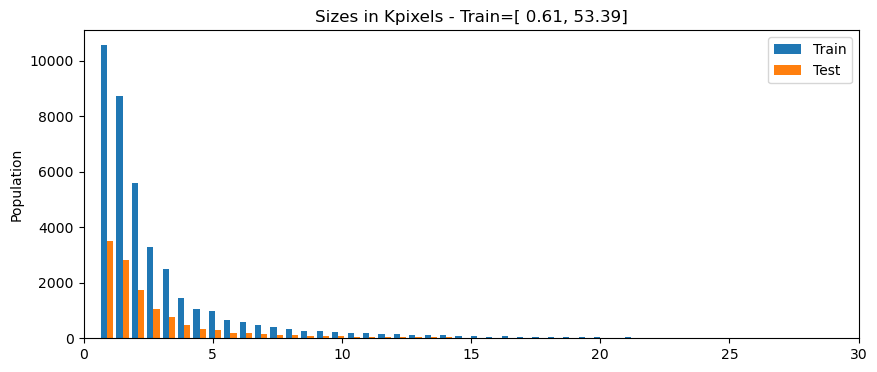

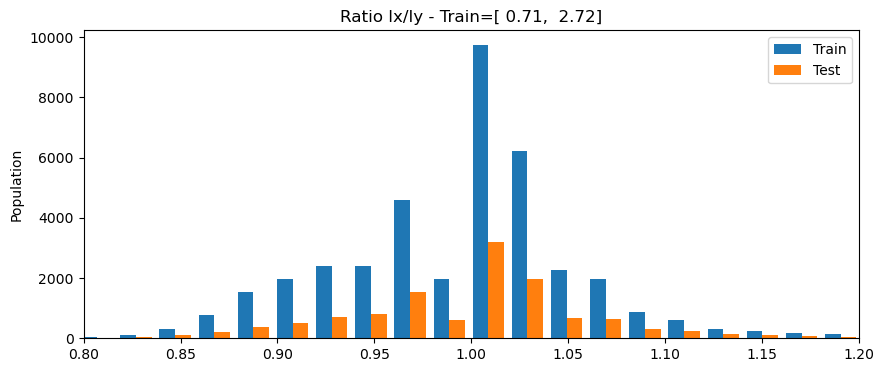

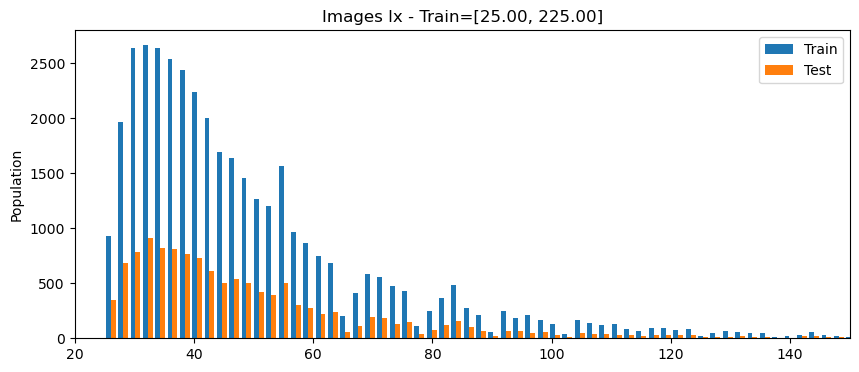

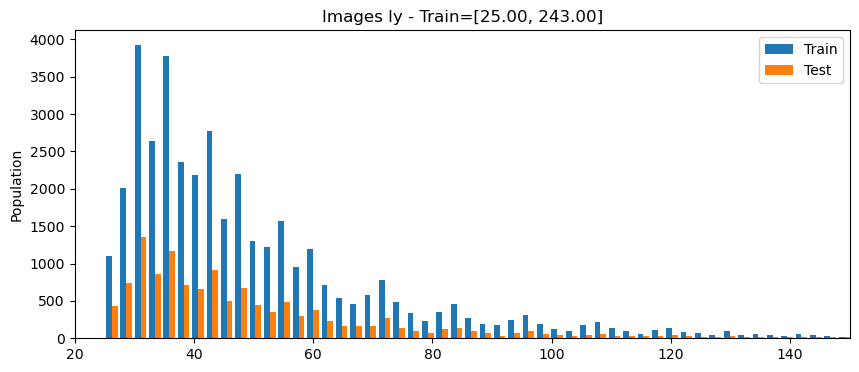

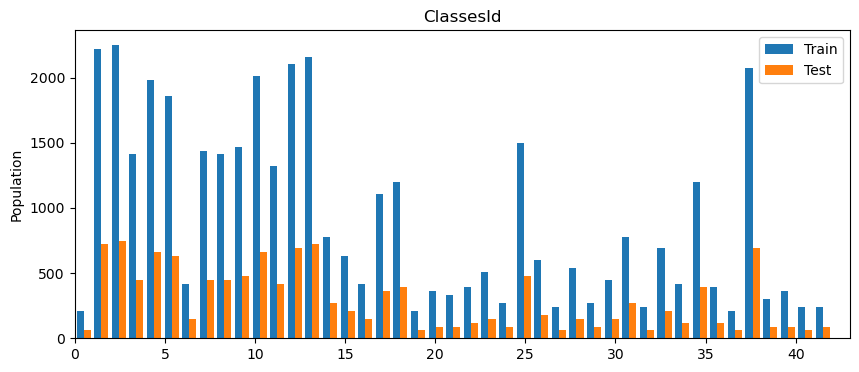

In [9]:
figsize=(10,4)
# ------ Global stuff
print("x_train shape : ",x_train.shape)
print("y_train shape : ",y_train.shape)
print("x_test  shape : ",x_test.shape)
print("y_test  shape : ",y_test.shape)

# ------ Statistics / sizes
plt.figure(figsize=figsize)
plt.hist([train_size,test_size], bins=100)
plt.gca().set(title='Sizes in Kpixels - Train=[{:5.2f}, {:5.2f}]'.format(min(train_size),max(train_size)), 
              ylabel='Population', xlim=[0,30])
plt.legend(['Train','Test'])
plt.savefig('img/01-stats-sizes.png')
plt.show()

# ------ Statistics / ratio lx/ly
plt.figure(figsize=figsize)
plt.hist([train_ratio,test_ratio], bins=100)
plt.gca().set(title='Ratio lx/ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ratio),max(train_ratio)), 
              ylabel='Population', xlim=[0.8,1.2])
plt.legend(['Train','Test'])
plt.savefig('img/02-stats-ratios.png')
plt.show()

# ------ Statistics / lx
plt.figure(figsize=figsize)
plt.hist([train_lx,test_lx], bins=100)
plt.gca().set(title='Images lx - Train=[{:5.2f}, {:5.2f}]'.format(min(train_lx),max(train_lx)), 
              ylabel='Population', xlim=[20,150])
plt.legend(['Train','Test'])
plt.savefig('img/03-stats-lx.png')
plt.show()

# ------ Statistics / ly
plt.figure(figsize=figsize)
plt.hist([train_ly,test_ly], bins=100)
plt.gca().set(title='Images ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ly),max(train_ly)), 
              ylabel='Population', xlim=[20,150])
plt.legend(['Train','Test'])
plt.savefig('img/04-stats-ly.png')
plt.show()

# ------ Statistics / classId
plt.figure(figsize=figsize)
plt.hist([y_train,y_test], bins=43)
plt.gca().set(title='ClassesId', ylabel='Population', xlim=[0,43])
plt.legend(['Train','Test'])
plt.savefig('img/05-stats-classes.png')
plt.show()

# Step 5 - List of classes
What are the 43 classes of our images...

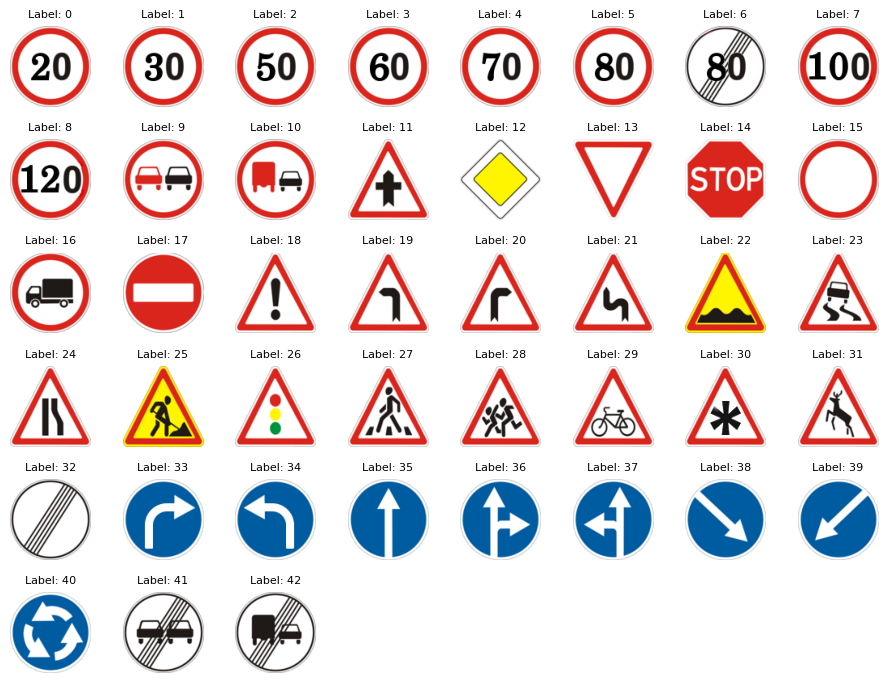

In [10]:
# Nombre d'images à afficher
n_images = 43
columns = 8
rows = (n_images + columns - 1) // columns  # Calcul du nombre de lignes nécessaires
x_size=1.4
y_size=1.4
cm='binary'

# Création de la figure et des axes
fig, axes = plt.subplots(rows, columns, figsize=(columns * x_size, rows * y_size))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Aplatir le tableau d'axes pour un accès plus facile
axes = axes.flatten()

# Boucle pour afficher chaque image
for i in range(n_images):
    ax = axes[i]
    ax.imshow(x_meta[i], cmap=cm, aspect='auto')  # Affiche l'image avec le colormap spécifié
    ax.set_title(f'Label: {y_meta[i]}', fontsize=8)  # Affiche l'étiquette
    ax.axis('off')  # Désactive les axes

# Masquer les axes restants s'il y en a
for i in range(n_images, len(axes)):
    axes[i].axis('off')

# Sauvegarder la figure si nécessaire
plt.savefig('img/06-meta-signs.png', dpi=300)

# Afficher la figure
plt.show()


# Step 6 - What does it really look like

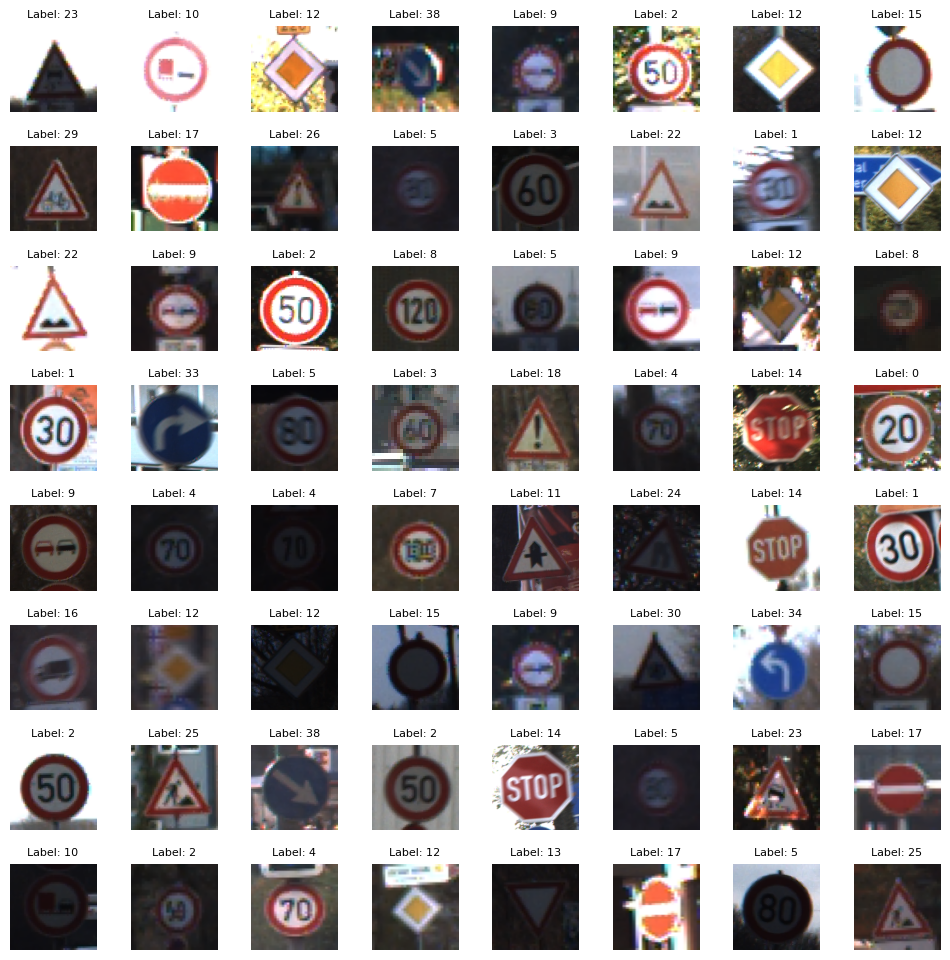

In [11]:
# Nombre d'images à afficher et leurs dimensions dans la figure
columns = 8
x_size = 1.5
y_size = 1.5
n_samples = 64

# Sélection aléatoire d'indices d'échantillons
samples = [random.randint(0, len(x_train) - 1) for _ in range(n_samples)]

# Calcul du nombre de lignes nécessaires basé sur le nombre d'échantillons et de colonnes
rows = n_samples // columns if n_samples % columns == 0 else (n_samples // columns) + 1

# Création de la figure et des axes
fig, axes = plt.subplots(rows, columns, figsize=(columns * x_size, rows * y_size))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Aplatir le tableau d'axes pour un accès plus facile si nécessaire
axes = axes.ravel()

# Affichage des images sélectionnées
for idx, sample_idx in enumerate(samples):
    ax = axes[idx]
    ax.imshow(x_train[sample_idx], cmap='binary', aspect='auto')  # Affiche l'image
    if y_train is not None:
        ax.set_title(f'Label: {y_train[sample_idx]}', fontsize=8)  # Affiche l'étiquette
    ax.axis('off')

# Masquer les axes restants s'il y en a
for idx in range(len(samples), len(axes)):
    axes[idx].axis('off')

# Sauvegarder la figure si nécessaire
plt.savefig('img/07-real-signs.png', dpi=300)

# Afficher la figure
plt.show()


# Step 7 - dataset cooking...

Images **must** :
 - have the **same size** to match the size of the network,
 - be **normalized**.  
 
It is possible to work on **rgb** or **monochrome** images and to **equalize** the histograms. 

## 7.1 - Enhancement cooking
A nice function for preparing our data.  
Input: a set of images (numpy array)  
Output: a enhanced images, resized and reprocessed (numpy array)

In [12]:
def images_enhancement(images, width=25, height=25, proc='RGB'):
    '''
    Resize and convert images - doesn't change originals.
    Input images must be RGBA or RGB.
    Note: all outputs are fixed size numpy array of float32.
    Args:
        images :         images list.
        width, height :  new images size (25,25).
        proc :           RGB | RGB-HE | L | L-HE | L-LHE | L-CLAHE.
    Return:
        numpy array of enhanced images.
    '''
    lz = {'RGB': 3, 'RGB-HE': 3, 'L': 1, 'L-HE': 1, 'L-LHE': 1, 'L-CLAHE': 1}[proc]
    
    out = []
    for img in tqdm(images, desc='Enhancement: '):  # Utilisez tqdm ici pour la barre de progression
        # ---- if RGBA, convert to RGB
        if img.shape[2] == 4:
            img = color.rgba2rgb(img)
            
        # ---- Resize
        img = transform.resize(img, (width, height), anti_aliasing=True)

        # ---- RGB / Histogram Equalization
        if proc == 'RGB-HE':
            hsv = color.rgb2hsv(img)
            hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
            img = color.hsv2rgb(hsv)
        
       # ---- Grayscale
        if proc=='L':
            img=color.rgb2gray(img)
            
        # ---- Grayscale / Histogram Equalization
        if proc=='L-HE':
            img=color.rgb2gray(img)
            img=exposure.equalize_hist(img)
            
        # ---- Grayscale / Local Histogram Equalization
        if proc=='L-LHE':        
            img=color.rgb2gray(img)
            img = img_as_ubyte(img)
            img=rank.equalize(img, disk(10))/255.
        
        # ---- Grayscale / Contrast Limited Adaptive Histogram Equalization (CLAHE)
        if proc=='L-CLAHE':
            img=color.rgb2gray(img)
            img=exposure.equalize_adapthist(img)
            
        out.append(img)

    # ---- Reshape images
    out = np.array(out, dtype='float32').reshape(-1, width, height, lz)
    return out

## 7.2 - To get an idea of the different recipes

In [13]:
i=random.randint(0,len(x_train)-16)
x_samples = x_train[i:i+16]
y_samples = y_train[i:i+16]

datasets  = {}

datasets['RGB']      = images_enhancement( x_samples, width=25, height=25, proc='RGB'  )
datasets['RGB-HE']   = images_enhancement( x_samples, width=25, height=25, proc='RGB-HE'  )
datasets['L']        = images_enhancement( x_samples, width=25, height=25, proc='L'  )
datasets['L-HE']     = images_enhancement( x_samples, width=25, height=25, proc='L-HE'  )
datasets['L-LHE']    = images_enhancement( x_samples, width=25, height=25, proc='L-LHE'  )
datasets['L-CLAHE']  = images_enhancement( x_samples, width=25, height=25, proc='L-CLAHE'  )

Enhancement: 100%|██████████| 16/16 [00:00<00:00, 134.33it/s]


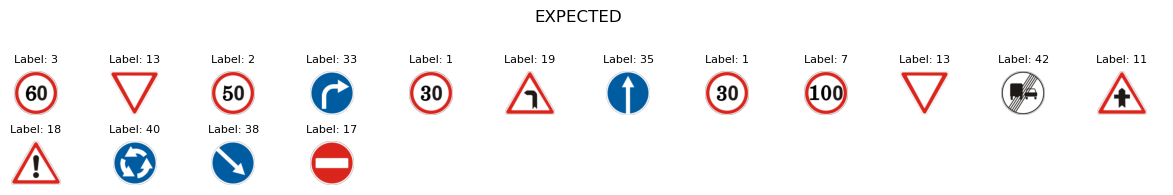

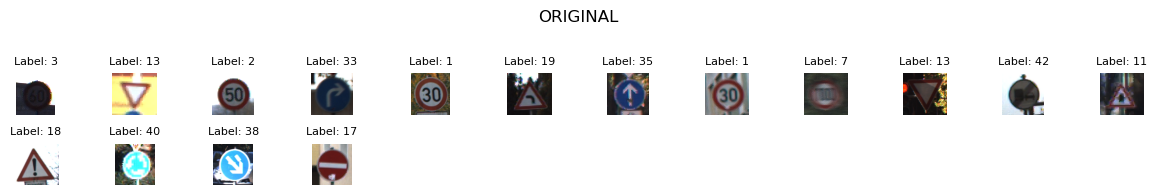

Dataset: RGB  min,max=[0.015,1.000]  shape=(16, 25, 25, 3)


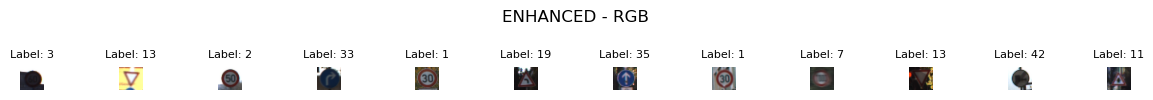

Dataset: RGB-HE  min,max=[0.001,1.000]  shape=(16, 25, 25, 3)


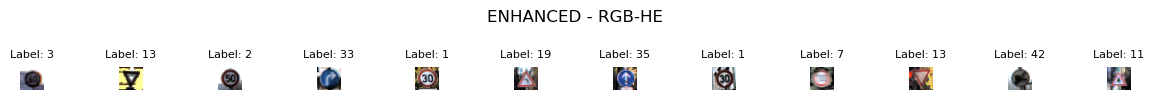

Dataset: L  min,max=[0.049,1.000]  shape=(16, 25, 25, 1)


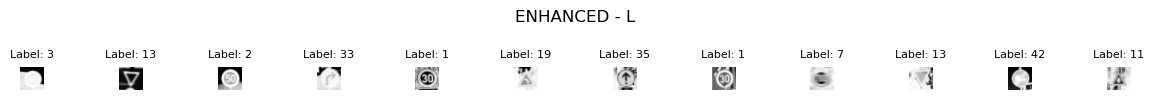

Dataset: L-HE  min,max=[0.002,1.000]  shape=(16, 25, 25, 1)


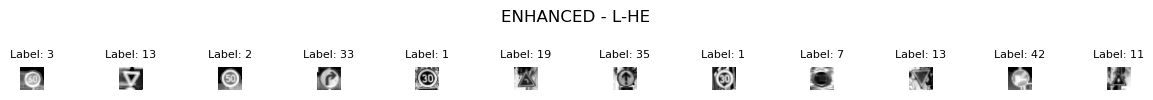

Dataset: L-LHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


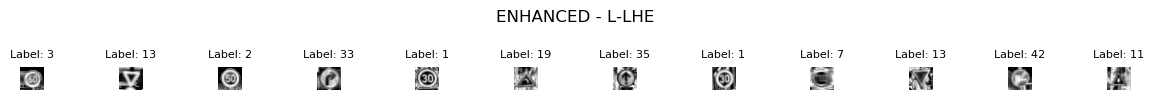

Dataset: L-CLAHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


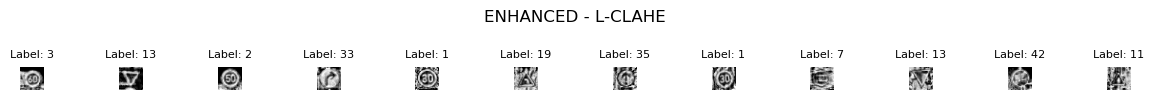

In [14]:
def display_images(images, labels, title, columns=12, x_size=1, y_size=1, save_as=None):
    rows = len(images) // columns + (1 if len(images) % columns else 0)
    fig, ax = plt.subplots(rows, columns, figsize=(x_size * columns, y_size * rows))
    plt.suptitle(title)
    
    for i in range(rows * columns):
        if i < len(images):
            if rows > 1:
                ax[i // columns, i % columns].imshow(images[i], cmap='binary')
                ax[i // columns, i % columns].set_title(f'Label: {labels[i]}', fontsize=8)
                ax[i // columns, i % columns].axis('off')
            else:
                ax[i].imshow(images[i], cmap='binary')
                ax[i].set_title(f'Label: {labels[i]}', fontsize=8)
                ax[i].axis('off')
        else:
            if rows > 1:
                ax[i // columns, i % columns].axis('off')
            else:
                ax[i].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    if save_as:
        plt.savefig(save_as + '.png', dpi=300)
    plt.show()

# Exemple d'utilisation pour "Expected"
x_expected = [x_meta[i] for i in y_samples]
display_images(x_expected, y_samples, 'EXPECTED', save_as='img/08-expected')

# Exemple d'utilisation pour "Original"
display_images(x_samples, y_samples, 'ORIGINAL', save_as='img/09-original')

# Exemple d'utilisation pour "Enhanced"
n = 10
for k, d in datasets.items():
    print(f"Dataset: {k}  min,max=[{d.min():.3f},{d.max():.3f}]  shape={d.shape}")
    display_images(d[:12], y_samples[:12], f'ENHANCED - {k}', save_as=f'img/{n}-enhanced-{k}')
    n += 1

## 7.3 - Cook and save

A function to save a dataset (h5 file)

In [15]:
def save_h5_dataset(x_train, y_train, x_test, y_test, x_meta,y_meta, filename):
        
    # ---- Create h5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_test",  data=x_test)
        f.create_dataset("y_test",  data=y_test)
        f.create_dataset("x_meta",  data=x_meta)
        f.create_dataset("y_meta",  data=y_meta)
        
    # ---- done
    size=os.path.getsize(filename)/(1024*1024)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)'.format(filename, str(x_train.shape),size))

Generate enhanced datasets :

In [16]:
# ---- Size and processings
#
all_size= [24, 48]
all_proc=['RGB', 'RGB-HE', 'L', 'L-LHE']

# ---- Do it
#
time_start = time.time()

n_train = int( len(x_train)*scale )
n_test  = int( len(x_test)*scale )

print('Parameters :')
print(f'Scale is : {scale}')
print(f'x_train length is : {n_train}')
print(f'x_test  length is : {n_test}')
print(f'output dir is     : {output_dir}\n')

print('Running...')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for s in all_size:
    for m in all_proc:
        filename = f'{output_dir}/set-{s}x{s}-{m}.h5'
        print(f'Dataset : {filename}')
        
        x_train_new = images_enhancement(x_train[:n_train], width=s, height=s, proc=m)
        x_test_new = images_enhancement(x_test[:n_test], width=s, height=s, proc=m)
        x_meta_new = images_enhancement(x_meta, width=s, height=s, proc='RGB')
        
        save_h5_dataset(x_train_new, y_train[:n_train], x_test_new, y_test[:n_test], x_meta_new, y_meta, filename)

x_train_new, x_test_new = 0, 0  # Pour libérer la mémoire, si nécessaire

print('\nDone.')
end_time = time.time()
print(f'Time elapsed: {end_time - start_time} seconds')


Parameters :
Scale is : 0.2
x_train length is : 7841
x_test  length is : 2526
output dir is     : ./data

Running...
Dataset : ./data/set-24x24-RGB.h5


Enhancement: 100%|██████████| 43/43 [00:00<00:00, 763.08it/s]


Dataset : ./data/set-24x24-RGB.h5   shape : (7841, 24, 24, 3)      size :   68.7 Mo   (saved)
Dataset : ./data/set-24x24-RGB-HE.h5


Enhancement: 100%|██████████| 43/43 [00:00<00:00, 591.17it/s]


Dataset : ./data/set-24x24-RGB-HE.h5  shape : (7841, 24, 24, 3)      size :   68.7 Mo   (saved)
Dataset : ./data/set-24x24-L.h5


Enhancement: 100%|██████████| 43/43 [00:00<00:00, 602.59it/s]


Dataset : ./data/set-24x24-L.h5     shape : (7841, 24, 24, 1)      size :   23.1 Mo   (saved)
Dataset : ./data/set-24x24-L-LHE.h5


Enhancement: 100%|██████████| 43/43 [00:00<00:00, 463.61it/s]


Dataset : ./data/set-24x24-L-LHE.h5  shape : (7841, 24, 24, 1)      size :   23.1 Mo   (saved)
Dataset : ./data/set-48x48-RGB.h5


Enhancement: 100%|██████████| 43/43 [00:00<00:00, 183.22it/s]


Dataset : ./data/set-48x48-RGB.h5   shape : (7841, 48, 48, 3)      size :  274.6 Mo   (saved)
Dataset : ./data/set-48x48-RGB-HE.h5


Enhancement: 100%|██████████| 43/43 [00:00<00:00, 170.25it/s]


Dataset : ./data/set-48x48-RGB-HE.h5  shape : (7841, 48, 48, 3)      size :  274.6 Mo   (saved)
Dataset : ./data/set-48x48-L.h5


Enhancement: 100%|██████████| 43/43 [00:00<00:00, 191.65it/s]


Dataset : ./data/set-48x48-L.h5     shape : (7841, 48, 48, 1)      size :   92.3 Mo   (saved)
Dataset : ./data/set-48x48-L-LHE.h5


Enhancement: 100%|██████████| 43/43 [00:00<00:00, 187.50it/s]

Dataset : ./data/set-48x48-L-LHE.h5  shape : (7841, 48, 48, 1)      size :   92.3 Mo   (saved)

Done.
Time elapsed: 205.82721281051636 seconds


# Step 8 - Reload data to be sure

dataset loaded from h5 file.


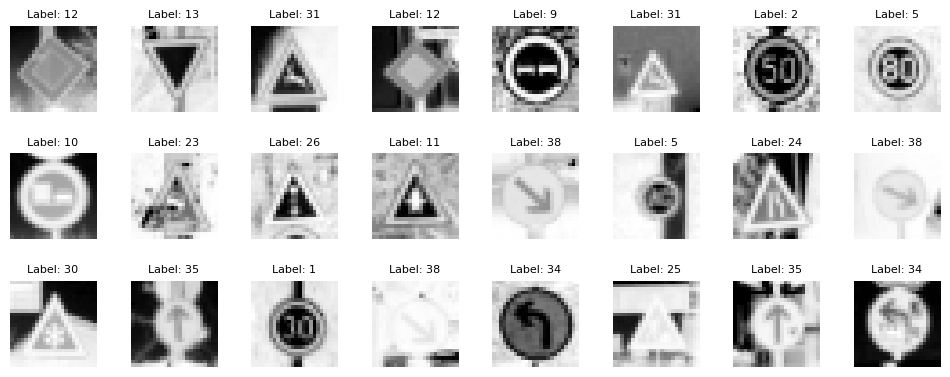

In [17]:
time_start = time.time()

dataset='set-24x24-L'
samples=range(24)

with  h5py.File(f'{output_dir}/{dataset}.h5','r') as f:
    x_tmp = f['x_train'][:]
    y_tmp = f['y_train'][:]
    print("dataset loaded from h5 file.")

def display_images(images, labels, samples, columns=8, x_size=1.5, y_size=1.5, cm='binary', save_as=None):
    # Calcul du nombre de lignes nécessaires
    n_samples = len(samples)
    rows = n_samples // columns if n_samples % columns == 0 else (n_samples // columns) + 1
    
    # Création de la figure
    fig, axes = plt.subplots(rows, columns, figsize=(x_size * columns, y_size * rows))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    # Aplatir le tableau d'axes pour un accès plus facile
    if rows * columns > 1:
        axes = axes.ravel()
    else:
        axes = np.array([axes])
    
    # Affichage des images
    for i, sample in enumerate(samples):
        ax = axes[i]
        ax.imshow(images[sample], cmap=cm)
        if labels is not None:
            ax.set_title(f'Label: {labels[sample]}', fontsize=8)
        ax.axis('off')

    # Masquer les axes restants s'il y en a
    for j in range(i + 1, rows * columns):
        axes[j].axis('off')

    # Sauvegarder la figure si nécessaire
    if save_as:
        plt.savefig(save_as + '.png', dpi=300)
    
    plt.show()

# Utilisation de la fonction pour afficher les images
display_images(x_tmp, y_tmp, samples, columns=8, x_size=1.5, y_size=1.5, cm='binary', save_as='img/16-enhanced_images')

end_time = time.time()
